# Lab 2
## Medical Patient No Show

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 10/28/2018

In [1]:
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit 
import datetime 
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load the data into variable 'df' from pickled object
from funcs import load_df
df = load_df()
# Make original to use later
df_orig = load_df()

In [78]:
df_temp['NoShow'] == 

0         False
1         False
2         False
3         False
4         False
5         False
6          True
7          True
8         False
9         False
10        False
11         True
12        False
13        False
14        False
15        False
16        False
17         True
18        False
19        False
20         True
21         True
22         True
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
110497    False
110498    False
110499    False
110500    False
110501    False
110502    False
110503    False
110504    False
110505    False
110506    False
110507    False
110508    False
110509    False
110510    False
110511    False
110512    False
110513    False
110514    False
110515     True
110516     True
110517    False
110518    False
110519    False
110520    False
110521    False
110522    False
110523    False
110524    False
110525    False
110526    False
Name: NoShow, Length: 11

In [80]:
#Create a temporary dataset to add a temp variable of NoShow as a number (0=False,1=True)
df_temp = pd.DataFrame()
df_temp['PatientId'] = df_orig['PatientId']
df_temp['NoShow'] = df_orig['NoShow']
df_temp['NoShow_num'] = np.where(df_temp['NoShow']== True, 1, 0)

#Create a subset dataframe which is basically a table pivoted (groupby) on PatientID
df_patient = pd.DataFrame()
df_patient['Appointments'] = df_temp.groupby(['PatientId'])['NoShow_num'].count()
df_patient['NoShow_sum'] = df_temp.groupby(['PatientId'])['NoShow_num'].sum()
df_patient['NoShow_percent'] = df_temp.groupby(['PatientId'])['NoShow_num'].sum() / df_temp.groupby(['PatientId'])['NoShow_num'].count()
df_patient['PatientID'] = df_temp.groupby(['PatientId'])['NoShow_num'].count().index
#reorder to put the PatientID first for aestetics b/c it would not work if I did this operation first
df_patient= df_patient.loc[0:,('PatientID','Appointments','NoShow_sum','NoShow_percent')]

df_patient[100:110]

,PatientID,Appointments,NoShow_sum,NoShow_percent
PatientId,,,,
1179448256,1179448256,3,0,0.00
1192462358,1192462358,1,0,0.00
1217364296,1217364296,4,1,0.25
1239925191,1239925191,1,0,0.00
1257286674,1257286674,5,1,0.20
1268142279,1268142279,2,0,0.00
1269422141,1269422141,2,0,0.00
1286321267,1286321267,2,0,0.00
1287268552,1287268552,2,1,0.50


## Data Preparation Part 1
#### [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

**Meetings Notes: 10/24 ** Chris - copy from MiniLab >> Define and prepare your class variables. 


#### Load and Prepare Dataset
We are using the same dataset from Lab1 and the minilab for the purposes of predicting noshow to clinical appointments. The dataset includes the additional created variables of age_range,  the split of date/time from Scheduled Day for deeper analysis, Scheduled day of week, Appointment day of week and days in advance the appointment was scheduled.

In [2]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null bool
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null category
AppointmentDOW    110527 non-null category
age_range         110527 non-null category
dtypes: bool(1), category(5), datetime64[ns](2), int64(10), object(1)
memory usage: 11.6+ MB


##### *note on date/time*
SciKitLearn models have difficulty working with complex objects such as datetime.datetime and datetime.time. To account for this, we will store all dates as ordinal values (the number of days since 1/1/1) and all time values as the number of elapsed seconds in the day (1:30PM = 13 * 3600 + 30 * 60).

In [3]:
# Convert date columns to ordinal integer values (days since 1/1/1)
dt_ord = lambda dt: dt.toordinal()
if 'ScheduledDay' in df:
    df['ScheduledDayOrdinal'] = df['ScheduledDay'].apply(dt_ord)
if 'AppointmentDay' in df:
    df['AppointmentDayOrdinal'] = df['AppointmentDay'].apply(dt_ord)

# Convert time values to seconds (total seconds since start of day)
to_secs = lambda t: t.hour * 3600 + t.minute * 60 + t.second
if 'ScheduledTime' in df:
    df['ScheduledTimeSeconds'] = df['ScheduledTime'].apply(to_secs)

In [4]:
df[['ScheduledDayOrdinal', 'ScheduledTimeSeconds', 'AppointmentDayOrdinal']].head()

,ScheduledDayOrdinal,ScheduledTimeSeconds,AppointmentDayOrdinal
0,736083,67088,736083
1,736083,58107,736083
2,736083,58744,736083
3,736083,62971,736083
4,736083,58043,736083


Next we will create dummy variables for our datsets class variables Handicap, AppointmentDOW, Scheduled DOW, Neighbourhood, and age range. We will also create the variable "ismale" to make dummy classification easier for gender.

In [5]:
#Remove attributes not usefull

del df['PatientId']
del df['AppointmentID']

# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# replace the current Gender attribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get rid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get rid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get rid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get rid of the original category as it is now one-hot encoded

if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
if 'ScheduledDay' in df:
    del df['ScheduledDay']
    
if 'ScheduledTime' in df:
    del df['ScheduledTime']

if 'AppointmentDay' in df:
    del df['AppointmentDay']

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Columns: 115 entries, Age to IsMale
dtypes: bool(1), int32(1), int64(10), uint8(103)
memory usage: 19.8 MB


## Data Preparation Part 2
#### [5 points] Describe the ﬁnal dataset that is used for classiﬁcation/regression (include a description of any newly formed variables you created).
**Meetings Notes 10/24:** Chris - copy from MiniLab

**Meeting Notes: ????** Luay wants add a field that ranks the patient's no show history. If they showed up twice and didn't show up 1 would be 33%. Create a temp dataset to group Patient and determine the # of no shows then merge the dataset and build the ranking. 


After removing the unnecessary variables and creating data variables, we're left with this final data set. 



| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| PatientID      | Interval  | Identifier            | Unique ID number for each patient.                                      |
| AppointmentID  | Interval  | Identifier            | Unique ID number for each appointment.                                  |
| Gender         | Nominal   | Binary Predictor      | Sex of the patient (Male/Female).                                       |
| ScheduledDay   | Interval  | Date/Time Predictor   | **Date** and **Time** when the patient called to schedule their appointment. Should always be before *AppointmentDay*.                                                                         |
| AppointmentDay | Interval  | Date Predictor        | Scheduled appointment **Date**. Appointment **Times** are not provided. |
| Age            | Ratio     | Integer Predictor     | Age of the patient in years.                                            |
| Neighbourhood  | Nominal   | Categorical Predictor | The neighborhood in which the appointment facility is located.          |
| Scholarship    | Ordinal   | Boolean Predictor     | Whether or not the patient receives Bolsa Família financial aid. To receive this benefit, a patient's income must be under the poverty threshold, all children in the household must be vaccinated and regularly attending school, and mothers and children must receive routine medical care.                                    |
| Hipertension   | Ordinal   | Boolean Predictor     | Whether or not a patient is classified as hypertensive (has high blood pressure).                                                                                                                     |
| Diabetes       | Ordinal   | Boolean Predictor     | Whether or not a patient is diagnosed as a diabetic.                    |
| Alcoholism     | Ordinal   | Boolean Predictor     | Whether or not a patient is classified as an alcoholic.                 |
| Handcap        | Ordinal   | Boolean Predictor     | Whether or not a patient is diagnosed as being handicapped.             |
| SMS_received   | Nominal   | Boolean Predictor     | Whether or not a patient received an SMS (text message) reminder for   their appointment.                                                                                                             |
| No-show        | Nominal   | Boolean Response      | Whether or not a patient showed up for their appointment. True means they **did not** show up, False means they **did** show up.                                                                         |

#### Created Variables
| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| DaysInAdvance  | Ratio     | Integer Predictor     | Value for how many days in advance the appointment was scheduled.       |
| ScheduledDOW   | Nominal   | Categorical Predictor | Day of the week for the day the patient scheduled the appointment.      |
| AppointmentDOW | Nominal   | Categorical Predictor | Day of the week for patient appointment.                                |
| ScheduledTime  | Interval  | Time Predictor        | **Time** of day when an appointment was scheduled.                      |
| age_range | Nominal   | Categorical Predictor | Age grouping of patient consisting of child (0-17), Adult (18-65), & senior (66+).


This dataset contains 110,527 appointment records for clinics located across the coastal city of Vitória in Espírito Santo, Brazil. The dataset includes 11 meaningful predictors relating to each appointment and to the patient that scheduled that appointment. Unique numeric identifiers are provided for each patient as well as for each appointment. The response variable of interest for this data set, No-show, is a boolean variable denoting whether or not a patient made it to their scheduled appointment.

In [6]:
print(df.dtypes)

Age                               int64
Scholarship                       int64
Hypertension                      int64
Diabetes                          int64
Alcoholism                        int64
SMSReceived                       int64
NoShow                             bool
DaysInAdvance                     int64
ScheduledDayOrdinal               int64
AppointmentDayOrdinal             int64
ScheduledTimeSeconds              int64
Handicap_0                        uint8
Handicap_1                        uint8
Handicap_2                        uint8
Handicap_3                        uint8
Handicap_4                        uint8
AppointmentDOW_Monday             uint8
AppointmentDOW_Tuesday            uint8
AppointmentDOW_Wednesday          uint8
AppointmentDOW_Thursday           uint8
AppointmentDOW_Friday             uint8
AppointmentDOW_Saturday           uint8
AppointmentDOW_Sunday             uint8
ScheduledDOW_Monday               uint8
ScheduledDOW_Tuesday              uint8


This dataset contains 110,527 appointment records for clinics located across the coastal city of Vitória in Espírito Santo, Brazil. The dataset includes 11 meaningful predictors relating to each appointment and to the patient that scheduled that appointment. Unique numeric identifiers are provided for each patient as well as for each appointment. The response variable of interest for this data set, No-show, is a boolean variable denoting whether or not a patient made it to their scheduled appointment.

In [7]:
df.describe()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,DaysInAdvance,ScheduledDayOrdinal,AppointmentDayOrdinal,ScheduledTimeSeconds,...,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,age_range_child,age_range_adult,age_range_senior,IsMale
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,...,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.089218,0.098266,0.197246,0.071865,0.030400,0.321026,10.183792,736092.856370,736103.040162,40557.666643,...,0.016611,0.017887,0.022148,0.028337,0.001375,0.007699,0.234060,0.645598,0.120342,0.350023
std,23.109921,0.297675,0.397921,0.258265,0.171686,0.466873,15.254924,19.140133,12.189325,11578.064436,...,0.127811,0.132541,0.147167,0.165934,0.037059,0.087409,0.423412,0.478334,0.325362,0.476979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,735912.000000,736083.000000,22176.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,736083.000000,736093.000000,30338.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,736094.000000,736102.000000,37983.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,736104.000000,736115.000000,50382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,736123.000000,736123.000000,77255.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#simple export of final dataset
df.to_csv("./data/df.csv", sep=',')

## Modeling and Evaluation 1

#### [10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

**Meetings Notes 10/24:** Chris - copy from MiniLab

Given the nature of no-show appointments and how they can impact business practicess, we must be cautious in how we score our models performance. 

If we were to purely prioritize accuracy, it is possible to get a optimal accuracy value with no precision relatively easily using some forms of SVM modeling with the linear kernel. This was noticed in the minilab and in practice the model predicted all patients as "show". While technically the best accuracy focused model, this has no business value.

If we were to purely prioritize model precision however, we may find ourselves in an equally troubled situation.  A model with higher precision is desirable as it will allow us to effectively predict No-show patients with a greater degree of certainty. However, if our increased precision comes at the expense of creating too many false negative no-show patients (or a show patient who was predicted as no-show).

Because of this, we need to balance a reasonable model yield that could be actionable with not creating to many false negative predictions. Therefore F1 score is likely the strongest metric for us to focus on as it will allow for a balance between precision and recall, and with the large amount of actual negatives (show patients), a F1 score is a reasonable metric to prioritize. It is critical to still consider total accuracy, precision, recall, and AUC to ensure our model does not drift to any extremes which will be our strategy for this effort.

## Modeling and Evaluation 2	

#### [10 points]	Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

**Meeting Notes:** Dana - to figure out error with SMOTE
Caroll to run CV on Training Set and evaluate the accuracy of Test

## Modeling and Evaluation 3

#### [20 points] Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

**Meeting Notes**: 
**Luay (Recursive Feature Elimination for Logistic) here**
	1. Logistic Caroll to move from MiniLab 
	2. RandomForest - Chris
	3. XGBoost/Gradient - Caroll

Response Gender
**Caroll to split training/text with Gender variable**
**Luay (Recursive Feature Elimination for Logistic) here**
	1. Logistic Caroll to move from MiniLab
	2. Random -- Chris
	3. XGBoost/Gradient-- Caroll


##### Partioning Data
We want to forecast future NoShows based on Appointment dates. We take the data we have and build a fixed training period in the past up to the last month. The last month of data will be used as testing dataset. Before we deploy the model we will rerun the models utilizing the entire dataset to predict the future outcomes.
This approach fits our dataset since we there is correlation between the appoointme date and whether or not they no-show.

#### Task 1 (Response: No-Show)

In [9]:
splitPerc = .3 # percentage

In [10]:
#Testing set --- hold 1 month of data out as test set based on AppointmentDay
df_test = df.copy()
# Calculation to find the ordinal value of AppointmentDay to split data at
X_test = df_test[df['AppointmentDayOrdinal'] >=  (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_test = X_test['NoShow'].values # get the labels we want.

if 'NoShow' in X_test:
    del X_test['NoShow'] # get rid of the class label

#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy() 
                 
X_train = df_train[df['AppointmentDayOrdinal'] < (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_train = X_train['NoShow'].values # get the labels we want.
del X_train['NoShow'] # get rid of the class label

if 'NoShow' in X_train:
    del X_train['NoShow'] # get rid of the class label

#All data
df_tmp = df.copy()
X = df_tmp
y = df_tmp['NoShow']
if 'NoShow' in X:
    del X['NoShow'] # get rid of the class label

In [49]:
num_cv_iterations = 10
num_instances = len(y)
seed = 123456789
cv_object = TimeSeriesSplit(n_splits=num_cv_iterations,
                         max_train_size= None,
                         )
                         
print(cv_object)

TimeSeriesSplit(max_train_size=None, n_splits=10)


In [12]:
print ('Number of Prediciting Features: ', X.shape)
print ('Number of Response: ', y.shape)
print ('Appointment Date Range (Trainig Set): ', min(X_train['AppointmentDayOrdinal']) ,' - ',  max(X_train['AppointmentDayOrdinal']))
print ('Number of Training Records:  Predictors: ', X_train.shape, 'Response: ' ,y_train.shape)
print ('Number of Test Records: Predictors: ',X_test.shape, 'Response: ' ,y_test.shape)
print ('Appointment Date Range (Test Set): ', min(X_test['AppointmentDayOrdinal']) ,' - ',  max(X_test['AppointmentDayOrdinal']))

Number of Prediciting Features:  (110527, 114)
Number of Response:  (110527,)
Appointment Date Range (Trainig Set):  736083  -  736109
Number of Training Records:  Predictors:  (75283, 114) Response:  (75283,)
Number of Test Records: Predictors:  (35244, 114) Response:  (35244,)
Appointment Date Range (Test Set):  736114  -  736123


#### Grid Search
<p>A grid search will help determine the optimal parameters to pass to the logistic regression function. Finding the optimal parameters will help with model prediction.</p>
<p>Some parameters are being selected as the only option due to the type of dataset. We will try using a solver with a default parameter 'lbfgs' for binomial problems, although sag and saga are faster for larger datasets.</p>
<p>The multi-class parameter is set to the default of 'ovr' because we have a binary problem.

In [13]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv_object):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv_object)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y, predictions)
    confMat = confusion_matrix(y, predictions)
    acc = accuracy_score(y, predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

Upon researching the possible parameters to LogisticRegression from sklearn, we decided that the most important parameters of interest were C (the inverse of regularization strength, which must be a positive floating point value) and max_iter (the maximum number of iterations for the lbfgs solver to use). The default values for these parameters are 1.0 and 100 respectively, and we have included a range of potential values for these parameters that might help improve our model accuracy.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = LogisticRegression()

parameters = {
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [47]:
#Diplay the top model parameters
LRestimator = regGridSearch.best_estimator_

In [48]:
LRestimator

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

RFECV ______________________________________________________ 

In [95]:
%%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#Create a regression estimator with best parameters for cross validation
classifierEst = LRestimator

rfecvLR = RFECV(estimator=classifierEst, step=1, cv=cv_object, scoring='accuracy')
rfecvLR.fit(X.values, y.values)

Wall time: 4min 49s


Optimal number of features : 110


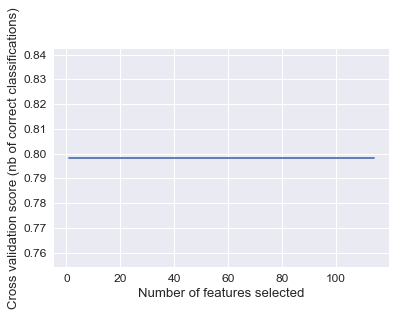

In [97]:
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecvLR.grid_scores_) + 1), rfecvLR.grid_scores_)
plt.show()

In [98]:
rfe_ft_imp_df = pd.DataFrame({'feature_names':X.columns, 'weights':rfecvLR.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )
rfe_ft_imp_df

,feature_names,weights
0,Age,0.798218
85,Neighbourhood_PRAIA DO SUÁ,0.798218
83,Neighbourhood_PONTAL DE CAMBURI,0.798218
82,Neighbourhood_PIEDADE,0.798218
81,Neighbourhood_PARQUE MOSCOSO,0.798218
80,Neighbourhood_PARQUE INDUSTRIAL,0.798218
79,Neighbourhood_NOVA PALESTINA,0.798218
78,Neighbourhood_NAZARETH,0.798218
77,Neighbourhood_MÁRIO CYPRESTE,0.798218
76,Neighbourhood_MORADA DE CAMBURI,0.798218


In [62]:
len(X.values)

110527

-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = RandomForestClassifier()

parameters = {
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.8s remaining:    3.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    8.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

<p>By performing a grid search, the best parameters to pass into the Logistic Regression are identified for us. Below is the best estimator parameters for class weight and cost without scaling the data. The optimal values were estimated to be 0.01 for C (100 times smaller than the default 1.0 value) and 500 for max_iter (5 times greater than the default value of 100).

In [17]:
#Diplay the top model parameters
RFestimator = regGridSearch.best_estimator_
RFestimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
RFestimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
%%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#Create a regression estimator with best parameters for cross validation
classifierEst = RFestimator

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv_object, scoring='accuracy')
rfecv.fit(X.values, y.values)

Wall time: 19min 50s


Optimal number of features : 110


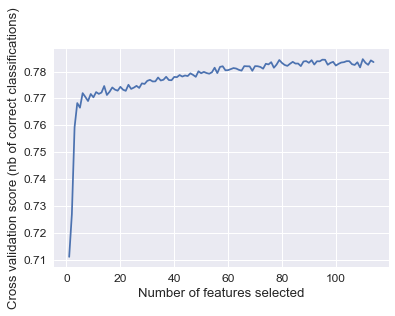

In [67]:
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [99]:
X

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,DaysInAdvance,ScheduledDayOrdinal,AppointmentDayOrdinal,ScheduledTimeSeconds,...,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,age_range_child,age_range_adult,age_range_senior,IsMale
0,62,0,1,0,0,0,0,736083,736083,67088,...,0,0,0,0,0,0,0,1,0,0
1,56,0,0,0,0,0,0,736083,736083,58107,...,0,0,0,0,0,0,0,1,0,1
2,62,0,0,0,0,0,0,736083,736083,58744,...,0,0,0,0,0,0,0,1,0,0
3,8,0,0,0,0,0,0,736083,736083,62971,...,0,0,0,0,0,0,1,0,0,0
4,56,0,1,1,0,0,0,736083,736083,58043,...,0,0,0,0,0,0,0,1,0,0
5,76,0,1,0,0,0,2,736081,736083,31011,...,0,0,0,0,0,0,0,0,1,0
6,23,0,0,0,0,0,2,736081,736083,54312,...,0,0,0,0,0,0,0,1,0,0
7,39,0,0,0,0,0,2,736081,736083,56398,...,0,0,0,0,0,0,0,1,0,0
8,21,0,0,0,0,0,0,736083,736083,28936,...,0,0,0,0,0,0,0,1,0,0
9,19,0,0,0,0,0,2,736081,736083,46105,...,0,0,0,0,0,0,0,1,0,0


In [102]:
len(rfecv.grid_scores_)

114

In [101]:
rfe_ft_imp_df = pd.DataFrame({'feature_names':X.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )
rfe_ft_imp_df

,feature_names,weights
109,Neighbourhood_VILA RUBIM,0.784602
94,Neighbourhood_SANTA LÚCIA,0.784403
95,Neighbourhood_SANTA MARTHA,0.784373
78,Neighbourhood_NAZARETH,0.784284
90,Neighbourhood_SANTA CECÍLIA,0.784214
112,age_range_senior,0.784145
88,Neighbourhood_RESISTÊNCIA,0.783876
103,Neighbourhood_SÃO BENEDITO,0.783856
104,Neighbourhood_SÃO CRISTÓVÃO,0.783846
92,Neighbourhood_SANTA HELENA,0.783826


---

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = XGBClassifier()


parameters = {
             }


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   56.0s remaining:   37.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [19]:
#Diplay the top model parameters
XGBestimator = regGridSearch.best_estimator_
XGBestimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# All

clf_array = [
    ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)),
    ('Random Trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
    ('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
    ]
print ('All Data: ')
for clf in clf_array:
    acc = cross_val_score(clf[1], X, y)
    
    print (clf[0], acc.mean())

All Data: 
Logistic 0.79806744073009
Random Trees 0.7811486507505282
XGBoost 0.7974703138481137


In [21]:
# Train
print ('Training Set: ')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_train,y_train)
      
    print (clf[0], acc.mean())

Training Set: 
Logistic 0.7903643588971825
Random Trees 0.7748363945589763
XGBoost 0.7898994609680732


In [22]:
#Test
print ('Testing Set: ')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_test,y_test)
    
    print (clf[0], acc.mean())

Testing Set: 
Logistic 0.814521620701396
Random Trees 0.7946317103620474
XGBoost 0.8142946317103621


**Using SMOTE to perform over-sampling for balancing response**

In [23]:
# Over-sampling using SMOTE to balance the NoShows
from imblearn.over_sampling import SMOTE
#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy()
X_train = df_train

y_train = X_train['NoShow'].values # get the labels we want.
del X_train['NoShow'] # get rid of the class label

if 'NoShow' in X_train:
    del X_train['NoShow'] # get rid of the class label

sm = SMOTE()
X_train_ovr, y_train_ovr = sm.fit_sample(X_train, y_train.ravel())
print("Proportion of response in train set using SMOTE")
for i in np.unique(y_train) :
    print("The number of {} is {} accouting for {}%.".format(i, np.bincount(y_train)[i], np.round(np.bincount(y_train)[i]/len(y_train), 3)*100 ))

for i in np.unique(y_train_ovr) :
    print("The number of {} is {} accouting for {}%.".format(i, np.bincount(y_train_ovr)[i], np.round(np.bincount(y_train_ovr)[i]/len(y_train_ovr), 3)*100 ))


Proportion of response in train set using SMOTE
The number of False is [] accouting for []%.
The number of True is [[88208 22319]] accouting for [[79.8 20.2]]%.
The number of False is [] accouting for []%.
The number of True is [[88208 88208]] accouting for [[50. 50.]]%.


**Showing below that our time series is pretty well stationary over time except for Saturday which show consistantly lower no show appointments**

In [24]:
df['NoShow'] = df['NoShow']
df['NoShow_num'] = np.where(df['NoShow']==True, 1, 0)

#Set dataframe with index as Appointment Day
ts = df[['AppointmentDayOrdinal', 'NoShow'] ]
ts = df.set_index('AppointmentDayOrdinal')
ts.groupby(['AppointmentDayOrdinal'])['NoShow'].sum()

AppointmentDayOrdinal
736083     633.0
736086     861.0
736087     831.0
736088     973.0
736089     807.0
736090     795.0
736093    1019.0
736094     992.0
736095     885.0
736096     837.0
736097     905.0
736098       9.0
736100    1049.0
736101     935.0
736102     890.0
736103     892.0
736104     899.0
736108     811.0
736109     759.0
736114     888.0
736115     767.0
736116     812.0
736117     802.0
736118     805.0
736121     873.0
736122     816.0
736123     774.0
Name: NoShow, dtype: float64

**Plot below shows the # of NoShow appointmets over time.**

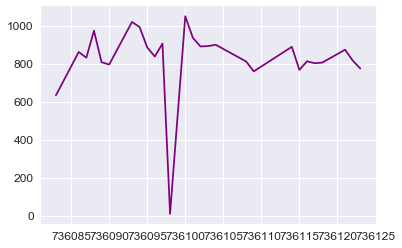

In [25]:
plt.plot(ts.groupby(['AppointmentDayOrdinal'])['NoShow'].sum(), color="purple")

#### Task 2 (Response: Gender)

In [26]:
#Testing set --- hold 1 month of data out as test set based on AppointmentDay
df_test = df.copy()
# Calculation to find the ordinal value of AppointmentDay to split data at
X_test2 = df_test[df['AppointmentDayOrdinal'] >=  (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_test2 = X_test2['IsMale'].values # get the labels we want.

if 'IsMale' in X_test2:
    del X_test2['IsMale'] # get rid of the class label

#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy() 
                 
X_train2 = df_train[df['AppointmentDayOrdinal'] < (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_train2 = X_train2['IsMale'].values # get the labels we want.
del X_train2['IsMale'] # get rid of the class label
if 'IsMale' in X_train2:
    del X_train2['IsMale'] # get rid of the class label

#All data
df_tmp = df.copy()
X2 = df_tmp
y2 = df_tmp['IsMale']
if 'IsMale' in X2:
    del X2['IsMale'] # get rid of the class label

In [27]:
print ('Number of Prediciting Features: ', X2.shape)
print ('Number of Response: ', y2.shape)
print ('Appointment Date Range (Trainig Set): ', min(X_train2['AppointmentDayOrdinal']) ," - ",  max(X_train2['AppointmentDayOrdinal']))
print ('Number of Training Records: ', "Predictors: ", X_train2.shape, "Response:" ,y_train2.shape)
print ('Number of Test Records: ', "Predictors: ",X_test2.shape, "Response:" ,y_test2.shape)
print ('Appointment Date Range (Test Set): ', min(X_test2['AppointmentDayOrdinal']) ," - ",  max(X_test2['AppointmentDayOrdinal']))

Number of Prediciting Features:  (110527, 115)
Number of Response:  (110527,)
Appointment Date Range (Trainig Set):  736083  -  736109
Number of Training Records:  Predictors:  (75283, 115) Response: (75283,)
Number of Test Records:  Predictors:  (35244, 115) Response: (35244,)
Appointment Date Range (Test Set):  736114  -  736123


#### Grid Search
<p>A grid search will help determine the optimal parameters to pass to the logistic regression function. Finding the optimal parameters will help with model prediction.</p>
<p>Some parameters are being selected as the only option due to the type of dataset. We will try using a solver with a default parameter 'lbfgs' for binomial problems, although sag and saga are faster for larger datasets.</p>
<p>The multi-class parameter is set to the default of 'ovr' because we have a binary problem.

In [28]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X2, y2, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X2, y2, scoring=['accuracy','precision','recall']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X2, y2, cv_object):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X2, y2, cv=cv_object)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y2, predictions)
    confMat = confusion_matrix(y2, predictions)
    acc = accuracy_score(y2, predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = LogisticRegression()

parameters = {
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [30]:
#Diplay the top model parameters
LRestimator2 = regGridSearch.best_estimator_
LRestimator2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = RandomForestClassifier()

parameters = {
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    8.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   12.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

<p>By performing a grid search, the best parameters to pass into the Logistic Regression are identified for us. Below is the best estimator parameters for class weight and cost without scaling the data. The optimal values were estimated to be 0.01 for C (100 times smaller than the default 1.0 value) and 500 for max_iter (5 times greater than the default value of 100).

In [32]:
#Diplay the top model parameters
RFestimator2 = regGridSearch.best_estimator_
RFestimator2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = XGBClassifier()


parameters = {
             }


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   57.9s remaining:   38.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [34]:
#Diplay the top model parameters
XGBestimator2 = regGridSearch.best_estimator_
XGBestimator2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# All

clf_array = [
    ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)),
    ('Random Trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
    ('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
    ]
print('All Data')
for clf in clf_array:
    acc = cross_val_score(clf[1], X2, y2)
    
    print (clf[0], acc.mean())

All Data
Logistic 0.6499769288124675
Random Trees 0.6438336989929371
XGBoost 0.669085391786314


In [36]:
# Train
print('Training Set')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_train2,y_train2)
    
    print (clf[0], acc.mean())

Training Set
Logistic 0.6482738469139392
Random Trees 0.6394005915058972
XGBoost 0.6682118885775564


In [37]:
#Test
print('Testing Set')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_test2,y_test2)
    
    print (clf[0], acc.mean())

Testing Set
Logistic 0.6536148004241641
Random Trees 0.6451875998240871
XGBoost 0.6718873756432718


## Modeling and Evaluation 4

#### [10 points] Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

**Meeting Notes**  Precision, recall, F-measure, ROC, AUC

In [38]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LRestimator, X, y, cv_object)

C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefi

The average accuracy for all cv folds is: 			 0.79822
The average precision for all cv folds is: 			 0.0
The average recall for all cv folds is: 			 0.0
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
0,0.798248,0.0,0.0
1,0.791281,0.0,0.0
2,0.792575,0.0,0.0
3,0.793471,0.0,0.0
4,0.744600,0.0,0.0
5,0.808301,0.0,0.0
6,0.832487,0.0,0.0
7,0.803623,0.0,0.0
8,0.825122,0.0,0.0
9,0.792475,0.0,0.0


In [39]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(RFestimator, X, y, cv_object)

The average accuracy for all cv folds is: 			 0.78417
The average precision for all cv folds is: 			 0.36311
The average recall for all cv folds is: 			 0.093618
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.776351,0.342407,0.117908
1,0.779835,0.381443,0.088221
2,0.774958,0.351261,0.100288
3,0.775356,0.342561,0.095422
4,0.733950,0.414125,0.100546
5,0.799542,0.420578,0.120976
6,0.815766,0.329268,0.096257
7,0.795561,0.404706,0.087177
8,0.810192,0.309645,0.069437
9,0.780233,0.335121,0.059952


In [68]:
EvaluateClassifierEstimator(RFestimator, X, y, cv_object)

The average accuracy for all cv folds is: 			 0.78387
The average precision for all cv folds is: 			 0.35688
The average recall for all cv folds is: 			 0.0913
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.777147,0.311388,0.086334
1,0.775256,0.336049,0.078684
2,0.776550,0.366057,0.105566
3,0.775356,0.361280,0.114217
4,0.736538,0.441558,0.119252
5,0.799244,0.414634,0.114746
6,0.812083,0.291242,0.084967
7,0.795760,0.400000,0.080081
8,0.811685,0.314050,0.064883
9,0.779039,0.332506,0.064269


In [40]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(XGBestimator, X, y, cv_object)

C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The average accuracy for all cv folds is: 			 0.79815
The average precision for all cv folds is: 			 0.50397
The average recall for all cv folds is: 			 0.0025519
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.797452,0.333333,0.003947
1,0.791580,0.540541,0.009537
2,0.792873,0.600000,0.004319
3,0.792774,0.315789,0.002892
4,0.744202,0.250000,0.000779
5,0.808301,0.500000,0.000519
6,0.832487,0.500000,0.000594
7,0.803822,1.000000,0.001014
8,0.825122,0.000000,0.000000
9,0.792873,1.000000,0.001918


In [41]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LRestimator2, X2, y2, cv_object)

C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Luay\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefi

The average accuracy for all cv folds is: 			 0.65618
The average precision for all cv folds is: 			 0.0
The average recall for all cv folds is: 			 0.0
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.655021,0.0,0.0
1,0.683289,0.0,0.0
2,0.646661,0.0,0.0
3,0.638599,0.0,0.0
4,0.637802,0.0,0.0
5,0.675127,0.0,0.0
6,0.646462,0.0,0.0
7,0.680999,0.0,0.0
8,0.646860,0.0,0.0
9,0.650941,0.0,0.0


In [42]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(RFestimator2, X2, y2, cv_object)

The average accuracy for all cv folds is: 			 0.64398
The average precision for all cv folds is: 			 0.47325
The average recall for all cv folds is: 			 0.28242
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.623470,0.446398,0.380842
1,0.661989,0.447394,0.285984
2,0.645267,0.496565,0.285070
3,0.631631,0.482587,0.267144
4,0.642779,0.513951,0.253092
5,0.635214,0.415437,0.301777
6,0.642779,0.491015,0.284628
7,0.656315,0.432609,0.248362
8,0.645864,0.497093,0.240981
9,0.654524,0.509464,0.276305


In [43]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(XGBestimator2, X2, y2, cv_object)

The average accuracy for all cv folds is: 			 0.67152
The average precision for all cv folds is: 			 0.5427
The average recall for all cv folds is: 			 0.29866
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.656415,0.502572,0.394691
1,0.704489,0.558229,0.320867
2,0.668160,0.555441,0.304789
3,0.654325,0.540347,0.291380
4,0.659799,0.561491,0.277274
5,0.681796,0.519002,0.280331
6,0.666368,0.551493,0.301520
7,0.683289,0.506322,0.287363
8,0.666169,0.570700,0.220688
9,0.674430,0.561394,0.307670


## Modeling and Evaluation 5

#### [10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course

## Modeling and Evaluation 6

#### [10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment (5 points total) 

#### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work (10 points total) 

#### You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

**Meeting Notes** - We did this in MiniLab 1 with chart 
Possible to add Naives Bayes classification (Luay)